In [2]:
import os
import re
import dotenv
import numpy as np
import pandas as pd
from pprint import pprint

import catboost as cb

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [3]:
# Load environment variables
project_dir = os.path.join(os.path.abspath(''), os.pardir)
dotenv_path = os.path.join(project_dir, '.env')

dotenv.load_dotenv(dotenv_path)

True

In [4]:
X = pd.read_csv('/home/jovyan/git_projects/machine-learning-project/data/processed/X_catboost.csv', encoding='utf-8')
y = pd.read_csv('/home/jovyan/git_projects/machine-learning-project/data/processed/y_both.csv', encoding='utf-8')
y_log = pd.read_csv('/home/jovyan/git_projects/machine-learning-project/data/processed/y_log_both.csv', encoding='utf-8')

In [5]:
X = X.set_index('ID')
y = y.set_index('ID')
y_log = y_log.set_index('ID')

In [6]:
X['topic_lda'] = X.topic_lda.astype(str)
X['bert_keywords'] = X.bert_keywords.fillna('')

In [36]:
print(X.head())
print(y.head())

                                  has_any_image  hashtags_count  \
ID                                                                
urn:li:share:7015210047886524416           True               0   
urn:li:share:7015240414274158592           True               0   
urn:li:share:7015593540680351744           True               0   
urn:li:share:7015632542909276162           True               0   
urn:li:share:7015768702277066752           True               2   

                                  has_any_hashtag  week_posted  \
ID                                                               
urn:li:share:7015210047886524416            False           52   
urn:li:share:7015240414274158592            False           52   
urn:li:share:7015593540680351744            False            1   
urn:li:share:7015632542909276162            False            1   
urn:li:share:7015768702277066752             True            1   

                                  weekday_posted  day_posted  hour_

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42, stratify=X['fanpage_id'])

In [8]:
X_train = X_train.drop(columns=['fanpage_id'])
X_test = X_test.drop(columns=['fanpage_id'])
y_train = y_train.squeeze()
y_test = y_test.squeeze()

In [9]:
cat_features = ['bert_keywords', 'topic_lda', 'week_posted', 'day_posted', 'hour_posted', 'minute_posted', 'weekday_posted']

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2691 entries, urn:li:share:7033727211081760768 to urn:li:share:7064596931129282560
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   has_any_image          2691 non-null   bool   
 1   hashtags_count         2691 non-null   int64  
 2   has_any_hashtag        2691 non-null   bool   
 3   week_posted            2691 non-null   int64  
 4   weekday_posted         2691 non-null   int64  
 5   day_posted             2691 non-null   int64  
 6   hour_posted            2691 non-null   int64  
 7   minute_posted          2691 non-null   int64  
 8   length_text_posted     2691 non-null   int64  
 9   topic_lda              2691 non-null   object 
 10  sure_belongs_to_topic  2691 non-null   float64
 11  bert_keywords          2691 non-null   object 
dtypes: bool(2), float64(1), int64(7), object(2)
memory usage: 236.5+ KB


In [11]:
catboost_model = cb.CatBoostRegressor(
    loss_function='RMSE',
    logging_level='Silent'
)

grid = {
    'iterations': np.arange(50, 350, 100),
    'learning_rate': np.arange(0.1, 1.0, 0.25),
    'depth': [2, 4, 6, 8]
}

# Define the scoring metric for the grid search
scorer = make_scorer(r2_score)

grid_search = GridSearchCV(
    catboost_model,
    grid,
    scoring=scorer,
    cv = 10
)

# Perform the grid search
grid_search.fit(X_train, y_train, cat_features=cat_features)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

In [12]:
print(best_params)

{'depth': 6, 'iterations': 150, 'learning_rate': 0.1}


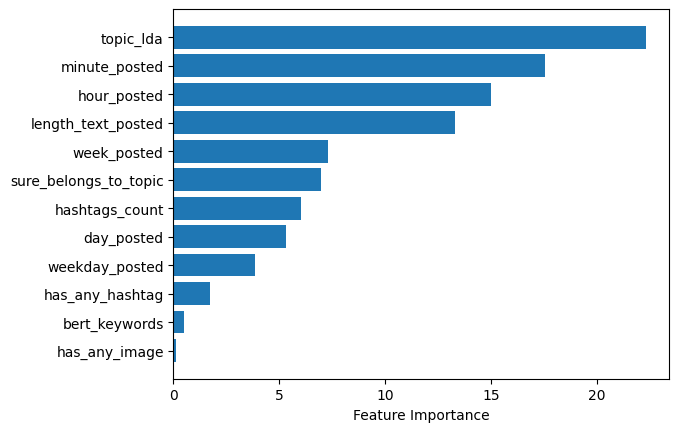

In [13]:
feature_importance = best_model.get_feature_importance(type=cb.EFstrType.FeatureImportance)
feature_names = X_train.columns

# Create a sorted index based on feature importance
sorted_idx = feature_importance.argsort()

# Plot feature importance
plt.barh(feature_names[sorted_idx], feature_importance[sorted_idx])
plt.xlabel('Feature Importance')
plt.show()

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score, explained_variance_score

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmsle = mean_squared_log_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame({'Metric': ['Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)',
                                      'Root Mean Squared Error (RMSE)', 'Root Mean Squared Logarithmic Error (RMSLE)',
                                      'R-squared (R^2)', 'Explained Variance Score'],
                            'Value': [mae, mse, rmse, rmsle, r2, explained_variance]})

In [15]:
metrics_df

,Metric,Value
0,Mean Absolute Error (MAE),0.095936
1,Mean Squared Error (MSE),0.016790
2,Root Mean Squared Error (RMSE),0.129578
3,Root Mean Squared Logarithmic Error (RMSLE),0.007169
4,R-squared (R^2),0.199950
5,Explained Variance Score,0.201050


In [22]:
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)

print(f"Train R-squared: {train_score:.2f}")
print(f"Test R-squared: {test_score:.2f}")

Train R-squared: 0.31
Test R-squared: 0.20


In [16]:
# get train/test predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

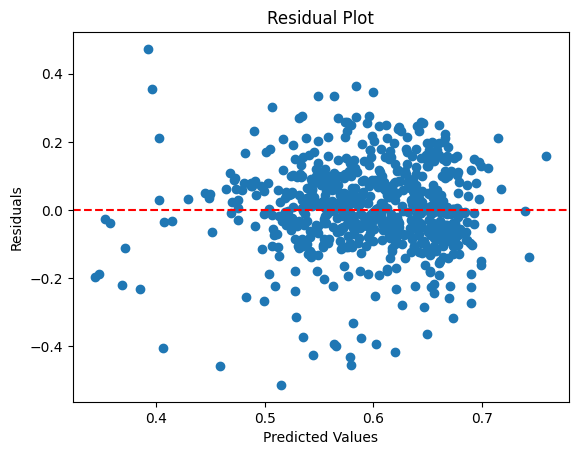

In [23]:
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.savefig('residual_plot_cb.png')
plt.show()

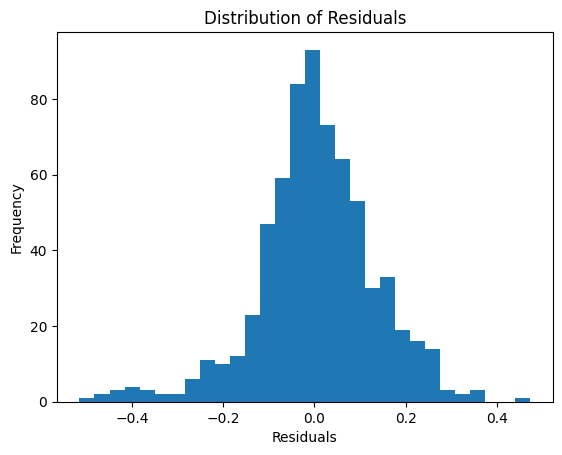

In [24]:
plt.hist(residuals, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.savefig('residual_distribution_cb.png')
plt.show()

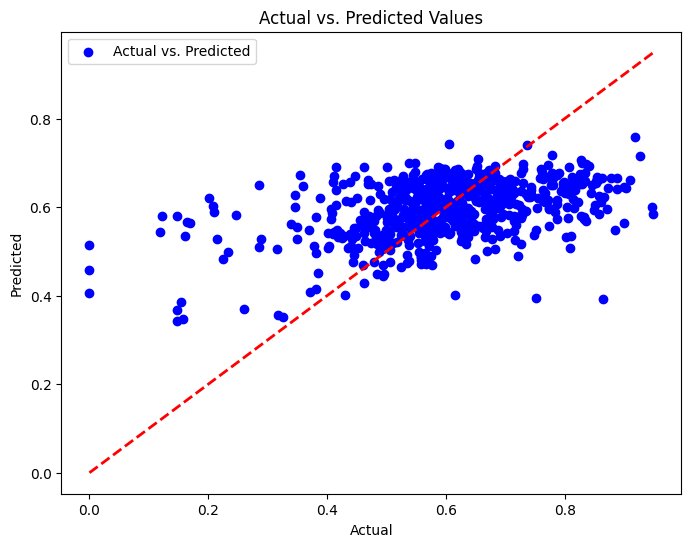

In [25]:
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Actual vs. Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.savefig('act_pred_cb.png')
plt.show()

In [21]:
# Save the model
best_model.save_model(os.path.join('/home/jovyan/git_projects/machine-learning-project/models', 'catboost_model.bin'))